<a href="https://colab.research.google.com/github/Trickshotblaster/nn-practices/blob/main/MLP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests

url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'

response = requests.get(url)

with open('names.txt', 'wb') as f:
  f.write(response.content)

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# stoi and itos
chars = sorted(list(set(''.join(words))))
stoi = {char:i+1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i:char for char, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
vocab_size = len(chars) + 1

In [7]:
block_size = 3

In [8]:
# make dataset
def build_dataset(words):
  X, Y = [], []
  for w in words:
    #print(w)
    context = [0] * block_size # list of zeros of length block size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '---->', itos[ix])
      context = context[1:] + [ix] # crop to remove previous, append new to end

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

X, Y = build_dataset(words)

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])
torch.Size([228146, 3]) torch.Size([228146])


In [9]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [10]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [11]:
n_embd = 10
n_hidden = 200

In [12]:
C = torch.randn((vocab_size, n_embd))
w1 = torch.randn(block_size*n_embd, n_hidden) * (5/3)/((n_embd * block_size)**0.5)
#b1 = torch.randn(n_hidden) * 0.01
w2 = torch.randn(n_hidden, vocab_size) * 0.01
b2 = torch.randn(vocab_size) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))
parameters = [C, w1, b1, w2, b2, bngain, bnbias]
weights = [C, w1, w2]
for p in parameters:
  p.requires_grad = True


In [13]:
sum(p.nelement() for p in parameters)

12297

In [14]:
lre = torch.linspace(-3, 0, 100000)
lrs = 10**lre


In [15]:
lri = []
lossi = []
stepi = []

In [16]:
max_steps = 200000
batch_size = 32

for x in range(max_steps):

  # minibatch
  ix = torch.randint(0, Xtr.shape[0], (batch_size, ))

  # forward
  # get input features
  emb = C[Xtr[ix]]
  # view the embeddings as [batch_size, (context_length * emb_dimension)]
  embcat = emb.view(-1, block_size * n_embd)
  # no bias anymore, but feed forward
  wi1b = embcat @ w1 # +b1
  # get the mean of the layer output, 0 and keepdim -> whole batch
  bnmeani = wi1b.mean(0, keepdim=True)
  bnstdi = wi1b.std(0, keepdim=True)
  # normalize the layer output with the mean and std, modify with gain, bias
  wi1b = bngain * (wi1b - bnmeani) / bnstdi + bnbias
  # feed into activation, gradients are now usable
  wi1ba = wi1b.tanh()
  # finish forward
  wi2 = wi1ba @ w2
  logits = wi2 + b2
  # keep track of running mean so it doesn't need to be recalculated
  # used for inference
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  # zero grad
  for p in parameters:
    p.grad = None

  # calculate loss with cross entropy, sprinkle on regularization
  # punish big weights and biases
  loss = F.cross_entropy(logits, Ytr[ix]) + (torch.tensor([w.mean() for w in weights]).mean() * 0.1)

  #log the loss
  if x % 5000 == 0:
    print(loss.item())
  # backward, calculate gradients
  loss.backward()
  # crappy learning rate scheduler
  lr = 0.001 if x < 100 else 0.2 / (1+((1e-5) * x))
  # update parameters
  for p in parameters:
    p.data += -lr * p.grad
  # log epochs and losses
  stepi.append(x)
  lossi.append(loss.log10().item())


print(loss.log10().item())

3.301650047302246
2.382357597351074
2.5903713703155518
2.281752586364746
2.2883567810058594
2.2859387397766113
1.894065499305725
2.454977512359619
2.1396336555480957
2.171459913253784
2.0207269191741943
2.296722173690796
2.132307529449463
2.094698667526245
1.811854362487793
2.190147638320923
1.915322184562683
2.2941622734069824
1.8385887145996094
2.3430237770080566
2.3262557983398438
2.4699902534484863
2.0929269790649414
1.8531785011291504
2.161961793899536
2.3078372478485107
2.349334955215454
2.1766483783721924
1.9963743686676025
1.8630586862564087
2.1750612258911133
2.015623092651367
2.182678461074829
2.269528865814209
1.9275833368301392
2.088768720626831
1.7599965333938599
1.9277771711349487
1.6490683555603027
2.1569786071777344
0.3717025816440582


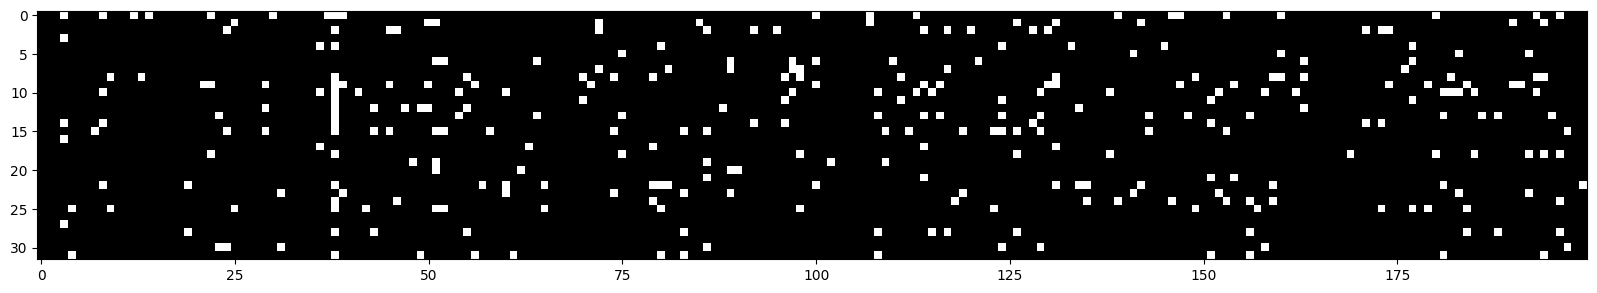

In [17]:
plt.figure(figsize=(20,10))
plt.imshow(wi1ba.abs() > 0.99, cmap='gray', interpolation='nearest')

(array([ 923.,  432.,  343.,  377., 1027., 1151.,  398.,  341.,  467.,
         941.]),
 array([-9.99999523e-01, -8.00003392e-01, -6.00007260e-01, -4.00011128e-01,
        -2.00014997e-01, -1.88648701e-05,  1.99977267e-01,  3.99973398e-01,
         5.99969530e-01,  7.99965662e-01,  9.99961793e-01]),
 <BarContainer object of 10 artists>)

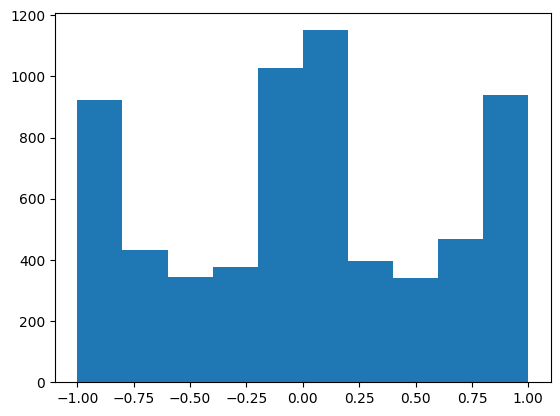

In [18]:
plt.hist(wi1ba.view(-1).tolist())

In [27]:
with torch.no_grad():
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 + b1
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [28]:
bnmean

tensor([[ 2.6511e-01,  1.5622e-01,  5.6435e-01,  5.1210e-01, -2.6010e-01,
         -9.5502e-01,  4.0514e-01, -9.2511e-01, -5.4534e-01,  1.7461e-01,
          7.8433e-01,  3.2004e-01,  1.8204e+00,  1.4014e+00,  1.8369e-01,
         -1.0571e-06, -5.5716e-01,  1.0136e-02,  1.4832e-01,  1.0869e+00,
         -4.5747e-01, -1.9200e-01,  9.6577e-01, -1.8797e+00,  1.8856e-02,
          9.1393e-01,  8.0252e-02,  2.8957e-02, -5.7934e-01, -8.6094e-01,
          1.7709e-01,  4.8370e-01,  6.3448e-01, -2.2465e-01,  1.0764e+00,
         -1.5862e-01, -8.2184e-01, -9.5544e-01,  2.9081e+00, -7.2929e-01,
         -5.9224e-01, -1.0206e+00, -6.9165e-01, -4.8001e-01, -7.2435e-01,
         -3.0413e-01, -6.7900e-01,  1.3231e+00,  5.8043e-01, -2.7087e-01,
         -1.0211e-02, -6.6698e-01, -1.1886e-01,  5.7266e-02, -2.0354e+00,
          7.1406e-01,  4.0104e-01, -1.0500e+00, -5.0345e-01, -5.2197e-01,
         -1.6251e-01, -4.7062e-01,  1.5510e+00,  8.9758e-01, -4.3914e-01,
          1.0200e+00, -5.4656e-01,  4.

(array([ 1.,  2., 10., 43., 57., 44., 24., 13.,  4.,  2.]),
 array([-2.77833343, -2.20968986, -1.64104629, -1.07240283, -0.50375926,
         0.06488431,  0.63352787,  1.20217144,  1.7708149 ,  2.33945847,
         2.90810204]),
 <BarContainer object of 10 artists>)

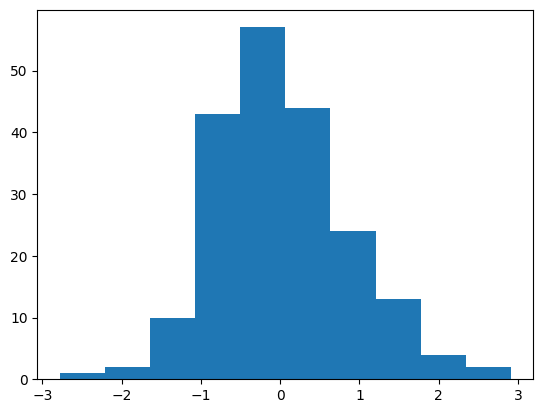

In [20]:
plt.hist(bnmean)

(array([ 5., 30., 19.,  4., 13., 49., 51., 20.,  6.,  3.]),
 array([1.2052716 , 1.50816751, 1.81106341, 2.11395931, 2.4168551 ,
        2.71975112, 3.0226469 , 3.32554293, 3.62843871, 3.93133473,
        4.23423052]),
 <BarContainer object of 10 artists>)

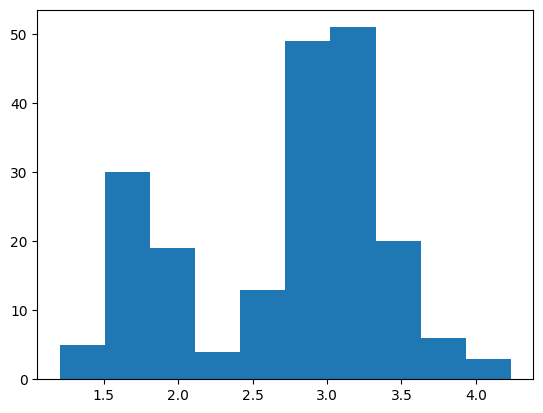

In [21]:
plt.hist(bnstd)

In [29]:
@torch.no_grad()
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte)
  }[split]
  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  wi1 = embcat @ w1
  wi1b = wi1 + b1
  wi1b = bngain * (wi1b - bnmean_running) / bnstd_running + bnbias
  wi1ba = wi1b.tanh()
  wi2 = wi1ba @ w2
  logits = wi2 + b2
  loss = F.cross_entropy(logits, y)
  return loss.item()

print('train', split_loss('train'))
print('val', split_loss('val'))

train 2.1058356761932373
val 2.142245054244995


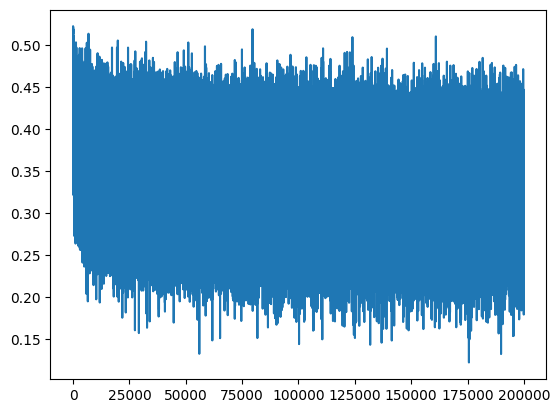

In [23]:
plt.plot(stepi, lossi)

In [24]:
def prompt(cx, max_length=15, samples=1):
  for x in range(samples):
    out = [stoi[c] for c in cx]
    if len(cx) > block_size:
      cx = cx[-block_size:]
    context = [0]*(block_size - len(cx)) + out
    while True:
      emb = C[context]
      wi1 = emb.view(-1, block_size * n_embd) @ w1
      wi1b = wi1 + b1
      wi1ba = wi1b.tanh()
      wi2 = wi1ba @ w2
      logits = wi2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    print(''.join(itos[i] for i in out))

prompt("bro", samples=10)

broxton.
browsishahly.
brock.
brotel.
brockespurhestephtis.
broghnoxxweoluwavajahabbky.
brockelizabeksencesseythan.
broxber.
brogesethm.
broxconfiellyxton.


In [25]:
prompt("z", samples=10)

zohristielliah.
zulavon.
zephtel.
zedrickleesahith.
zhasphnathaszoxiahirlishyleystafghn.
zaqipalbphtg.
zyshangelizzumarchastafbrockynsleygpighten.
zakingstly.
zhannahellanashyfabreslynestephtalicicelexxwphrashirajdazelilvinestwestephoramylesheppetel.
zacebastia.


In [26]:
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[context]
    wi1 = emb.view(-1, block_size * n_embd) @ w1
    wi1b = wi1 + b1
    wi1ba = wi1b.tanh()
    wi2 = wi1ba @ w2
    logits = wi2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))

qubfinezieldongtrett.
oraharajahristirmahicesavajaedamolowringslyn.
trishylossipham.
dakecharlystiahan.
codyicassiraidhag.
qub.
gie.
quisharshensenacileazfalestephten.
qubushyahielstoppiematthentas.
kaxsaidenesswaysenashwardaniahbbunty.
gzy.
javah.
khasrinesinglyn.
quelishanfercisponahyrtieelizahitrixfaxonow.
zhyn.
khaliahjaylahalucklor.
cacundyrosephan.
kishylique.
gladahels.
adrepstisochikishawquelyx.


In [ ]:
prompt('z', samples=10)
print('\n')
prompt('w', samples=10)

zayrittaida.
zakaremontriah.
zuly.
zamiki.
zavianna.
zamars.
zanniella.
zarvon.
zanna.
zad.


wend.
whanna.
wardoni.
wabell.
weson.
whanylon.
wer.
wen.
wretton.
wose.


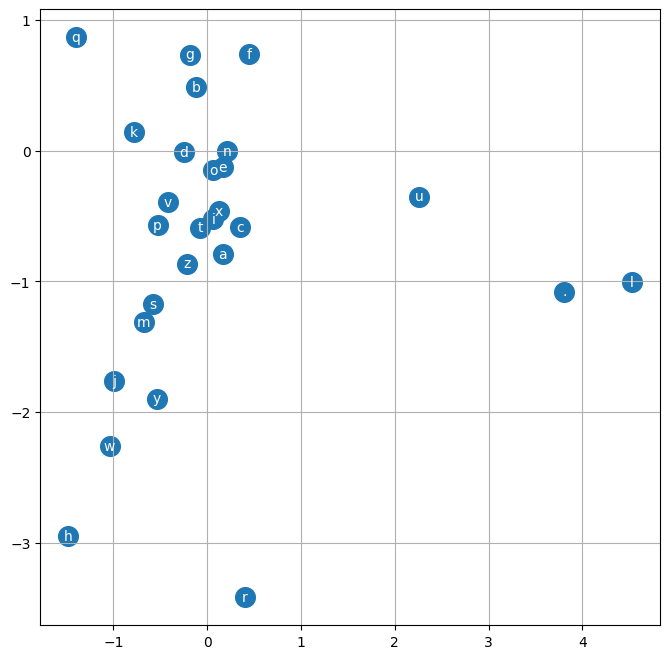

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i, 1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

thought it was overfitting for a second there

In [ ]:
torch.randint(0, X.shape[0], (32,))

tensor([213172,  33749, 118165, 118634, 212100,  75679,  20942,   7685, 159424,
        104630, 193800, 190421,  69472,  14163,  65536,   7638,  74692,  55967,
         18268, 151616,  68461,  73037, 130511, 196220,  25284, 118811,  17529,
         98684, 158170,  21724,  96713,  95438])

In [ ]:
# train, val, test split
# 80%, 10%, 10%
